In [1]:
import os
os.chdir("/Users/aliahmadi/Documents/Projects/RNA-Secondary-Structure-Prediction/notebook/EKH-25")

## Imports

In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.linalg import expm
from grammar.pcnf import PCNF
from Bio import Phylo, SeqIO
from copy import deepcopy
from io import StringIO
import networkx as nx
from math import log 
import numpy as np
import shutil
import pickle
import random

___

## Global Variables

In [4]:
predicted_struct = {}

## Pairing Charecters

In [5]:
def get_pair_start(pair_end):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return [val for val in pairing_chars if val[1] == pair_end][0][0]

In [6]:
def is_pair_start(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[0] for p in pairing_chars]

In [7]:
def is_pair_end(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[1] for p in pairing_chars]

## Create Tree

In [13]:
def create_tree(input_sequences, filename = "./outputs/tree.nwk", draw=False):
  names = list(input_sequences.keys())
  sequences = list(input_sequences.values())
  
  if len(names) <= 2:
    return None
  
  os.mkdir("./tmp")

  if len(names) > 2:
    phylip_file = "./tmp/sequences.phylip"
    with open(phylip_file, "w") as f:
      f.write(f"{len(sequences)} {len(sequences[0])}\n\n")
      for i, seq in enumerate(sequences):
        f.write(f"{names[i]}\t{seq}\n") 
    
    # !./phyml -i tmp/sequences.phylip -m GTR
    !./phyml -i tmp/sequences.phylip -m GTR > /dev/null 2>&1

    
    output_tree = Phylo.read(phylip_file + "_phyml_tree.txt", 'newick')

    output_tree.root_at_midpoint()
  
  for index, clade in enumerate(output_tree.find_clades()):
    if not clade.name:
      clade.name = str(index)
  
  shutil.rmtree("./tmp")
  Phylo.write(output_tree, filename, "newick")
  if draw:
    Phylo.draw(output_tree)
  
  return output_tree

## Get Mutation Probablities

In [18]:
def get_mutation_probablities(mutation_rate_values, time, order_array = ["A", "C", "G", "U"], gappy=False):
    mutation_rate_matrix = np.zeros((len(order_array), len(order_array)), np.float64)
    
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            mutation_rate_matrix[i_index,j_index] = mutation_rate_values[(i_value, j_value)]
    
    probability_rate_matrix = expm(mutation_rate_matrix * time)
    
    probability_rate_values = defaultdict(float)
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            probability_rate_values[(i_value, j_value)] = probability_rate_matrix[i_index,j_index]
            
    if gappy:      
        if order_array == ["A", "C", "G", "U"]:
            for i_index, i_value in enumerate(order_array):
                for _, j_value in enumerate(["-"]):
                    probability_rate_values[(i_value, j_value)] = 1
        else:
            for i_index, i_value in enumerate(order_array):
                for j_index, j_value in enumerate(['A-', '-A', 'C-', '-C', 'G-', '-G', 'U-', '-U', '--']):
                    if j_value == "--":
                        probability_rate_values[(i_value, j_value)] = 1
                    else:
                        __probability = 0
                        for nocleotid in ["A", "C", "G", "U"]:
                            __j_value = j_value.replace('-', nocleotid)
                            __probability += probability_rate_values[(i_value, __j_value)]
                                
                        probability_rate_values[(i_value, j_value)] = __probability
    
        
    return probability_rate_values

# Check Column

In [20]:
def column_needed(tuple1, tuple2):
    return len(tuple1) == len(tuple2) and all(t1 == t2 for t1, t2 in zip(tuple1, tuple2))

In [21]:
def get_columns(input_sequences, leaf_order):
    columns = defaultdict(list)
    
    for i in range(len(list(input_sequences.values())[0])):
        column = tuple([
            input_sequences[name][i] for name in leaf_order
        ])
        columns[column].append(i)
    return columns

In [22]:
def check_column(input_sequences, column, leaf_order):
    __leaf_order = leaf_order[-len(column):]
    columns = get_columns(input_sequences, __leaf_order)
    
    if len(column[0]) == 1:
        for _column, _places in columns.items():
            if column_needed(column, _column):
                return True
    else:
        for _column1, _places1 in columns.items():
            left_column = tuple(
                    pair[0] for pair in column if pair
            )
            if column_needed(left_column, _column1):
                for _column2, _places2 in columns.items():
                    right_column = tuple(
                        pair[1] for pair in column if pair
                    )
                    if _places2 != [] and column_needed(right_column, _column2):
                        if _places1[0] < _places2[-1]:
                            return True
    
    return False       

## Post Order Traversal

In [23]:
def post_order_traversal(tree, current_node, interior_possible_values, tips_possible_values, rate_values, input_sequences, leaf_order = []): 
    current_columns_probability = defaultdict(lambda: defaultdict(float))
    for child in current_node.clades:
        # going to add a branch with a single nucleotide 
        if child.is_terminal():
            leaf_order.append(child.name)
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, interior_possible_values, True)
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                for left_column in perv_columns_probability:
                    for child_value in tips_possible_values:
                        if check_column(input_sequences, left_column + (child_value ,), leaf_order):
                            for root in perv_columns_probability[left_column]:
                                current_columns_probability[left_column + (child_value ,)][root] = (
                                    mutation_probablities[(root, child_value)] * 
                                    perv_columns_probability[left_column][root]
                                )
                perv_columns_probability.clear()
            
            # haven't filled with any branch in last iteration
            else:
                # for mutation in mutation_probablities:
                for child_value in tips_possible_values:
                    if check_column(input_sequences, (child_value ,), leaf_order):
                        for parent_value in interior_possible_values:
                            current_columns_probability[(child_value ,)][parent_value] = mutation_probablities[(parent_value, child_value)]
        # going to add a branch with a more than one nucleotide 
        else:    
            inner_columns_probability, _ = post_order_traversal(tree, child, interior_possible_values, tips_possible_values, rate_values, input_sequences, leaf_order)
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, interior_possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                
                for left_column in perv_columns_probability:
                    for right_column in inner_columns_probability:
                        if check_column(input_sequences, left_column + right_column, leaf_order):
                            for root in perv_columns_probability[left_column]:
                                current_columns_probability[left_column + right_column][root] = sum(
                                    (
                                        mutation_probablities[(root, inner_root)] * 
                                        inner_columns_probability[right_column][inner_root] * 
                                        perv_columns_probability[left_column][root]
                                    ) for inner_root in inner_columns_probability[right_column])
                
                perv_columns_probability.clear()

            # haven't filled with some branch in last iteration
            else:
                for root_value in interior_possible_values:
                    for column in inner_columns_probability:
                        current_columns_probability[column][root_value] = sum(
                            (
                                mutation_probablities[(root_value, inner_root)] * 
                                inner_columns_probability[column][inner_root]
                            ) for inner_root in inner_columns_probability[column]
                        )
                    
    return current_columns_probability, leaf_order

## Get Columns Probability

In [24]:
def get_columns_probability(
    tree,  
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values,
    input_sequences,
):
    single_interior_possible_values = ['A', 'C', 'G', 'U']
    paired_interior_possible_values = [c1 + c2 for c1 in single_interior_possible_values for c2 in single_interior_possible_values]
    
    single_tips_possible_values = ['A', 'C', 'G', 'U', '-']
    paired_tips_possible_values = [c1 + c2 for c1 in single_tips_possible_values for c2 in single_tips_possible_values]
    
    __single_columns_probability, leaf_order = post_order_traversal(
        tree, 
        tree.root, 
        single_interior_possible_values,
        single_tips_possible_values, 
        single_rate_values,
        input_sequences,
        []
    )
    single_columns_probability = defaultdict(float)
    for column in __single_columns_probability:
        single_columns_probability[column] = sum(
            __single_columns_probability[column][root] 
            * single_frequencies[root] for root in single_interior_possible_values
        )
    __single_columns_probability.clear()
    
    
    __paired_columns_probability, _ = post_order_traversal(
        tree, 
        tree.root, 
        paired_interior_possible_values, 
        paired_tips_possible_values,
        paired_rate_values,
        input_sequences,
        [],
    )
    paired_columns_probability = defaultdict(float)
    for column in __paired_columns_probability:
        paired_columns_probability[column] = sum(
            __paired_columns_probability[column][root] 
            * paired_frequencies[root] for root in paired_interior_possible_values
        )
    __paired_columns_probability.clear()


    return single_columns_probability, paired_columns_probability, leaf_order

## Save PCFG

In [25]:
def save_pcfg(pcfg, filename):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    for A, B, C in binary_rules:
        print(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}")
            
    for A, w in unary_rules:
        print(f"{A} -> {w} {pcfg.q[(A, w)]}")
    
    with open(f"{filename}.pcfg", "w+") as pcfg_file:
        for A, B, C in binary_rules:
            pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}\n")
            
        for A, w in unary_rules:
            pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}\n")

## Extend Grammar

In [26]:
def extend_grammar(
    columns,
    pcfg,
    single_column_probs, 
    paired_column_probs,
    filename="Extended"
):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    with (open(f"{filename}.pcfg", "w+") as pcfg_file, open(f"{filename}.cfg", "w+") as cfg_file):
        for A, B, C in binary_rules:
            if A == "$M" and B == "B" and C == "F":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term} -> B{term.lower()} F {pcfg.q[(A, B, C)]}" + "\n")
                        cfg_file.write(f"{A+term} -> B{term.lower()} F" + "\n")
            elif B == "$M" and C == "E":
                for column, prob in paired_column_probs.items():
                    left_column = tuple(
                        pair[0] for pair in column if pair
                    )
                    right_column = tuple(
                        pair[1] for pair in column if pair
                    )
                    if columns.get(left_column, False) and columns.get(right_column, False):
                        left_term = str(left_column).replace(" ", "")
                        right_term = str(right_column).replace(" ", "")
                        pcfg_file.write(f"{A} -> $M{left_term} E{right_term.lower()} {pcfg.q[(A, B, C)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> $M{left_term} E{right_term.lower()}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}" + "\n")
                cfg_file.write(f"{A} -> {B} {C}" + "\n")

        for A, w in unary_rules:
            if w == "s":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A} -> {term} {pcfg.q[(A, w)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> {term}" + "\n")
            elif w == "d":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):      
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term.lower()} -> {term} {pcfg.q[(A, w)]}" + "\n")
                        cfg_file.write(f"{A+term.lower()} -> {term}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}" + "\n")
                cfg_file.write(f"{A} -> {w}" + "\n")

## Generate Parse Tree

In [27]:
def gen_parse_tree(tree, table, start, end, non_terminal = "S", firstRun = True, layer=1):
    if firstRun:
        tree.add_node((start, end, "S"), layer=layer)
        layer += 1
        
    if start == end and table[(start, end, non_terminal)]:
        if non_terminal.startswith("B"):
            predicted_struct[start] = "("
        elif non_terminal.startswith("E"):
            predicted_struct[start] = ")"
        else:
            predicted_struct[start] = "."

    for _start, _end, _non_terminal in table[(start, end, non_terminal)]:
        tree.add_node((_start, _end, _non_terminal), layer=layer)
        new_layer = layer + 1
        tree.add_edge((_start, _end, _non_terminal), (start, end, non_terminal))
        gen_parse_tree(tree, table, _start, _end, _non_terminal, firstRun=False, layer=new_layer)

## Draw Parse Tree

In [28]:
def draw_parse_tree(table, start_point, end_point, show=False):
    parse_tree = nx.Graph()
    
    gen_parse_tree(parse_tree, table, start_point, end_point)
    
    if show:
        pos = nx.multipartite_layout(parse_tree, subset_key ="layer")
        nx.draw(
            parse_tree, 
            pos, 
            # with_labels=True, 
            node_color='#74b9ff', 
            node_size=50, 
            font_size=10
        )
        nx.draw_networkx_nodes(
            parse_tree, 
            pos, 
            nodelist=[(start_point, end_point, "S")], 
            node_color='#0984e3', 
            node_size=50
        )

## Get Total Sequence

In [29]:
def get_total_sequence(input_sequences, leaf_order):
    total_sequence = ""
    columns = defaultdict(bool)
    for i in range(len(list(input_sequences.values())[0])):
        column = tuple([
            input_sequences[name][i] for name in leaf_order
        ])
        if column.count("<") == len(leaf_order):
            total_sequence += "< "
        elif column.count(">") == len(leaf_order):
            total_sequence += "> "
        else:
            columns[column] = True
            total_sequence += str(column).replace(" ", "") + " "
    return total_sequence, columns

## Remove Pairs

In [30]:
def remove_pairs(sequences, structure):
    nopair_sequences = defaultdict(str)
    nopair_sequences__ = defaultdict(str)
    
    for index, position in enumerate(structure):
        for name in sequences.keys():
            if is_pair_start(position):
                a = list(nopair_sequences[name])
                a.append("")
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append("<")
                nopair_sequences__[name] = "".join(a)
            elif is_pair_end(position):
                a = list(nopair_sequences[name])
                a.append("")
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append(">")
                nopair_sequences__[name] = "".join(a)
            else:
                a = list(nopair_sequences[name])
                a.append(sequences[name][index])
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append(sequences[name][index])
                nopair_sequences__[name] = "".join(a)

    return nopair_sequences, nopair_sequences__

___

In [31]:
# Load from the file
with open("./primaries/parameters/tRNA/frequencies.pkl", "rb") as file:
    (tRNA_single_frequencies, 
     tRNA_paired_frequencies, 
     tRNA_singles_prob, 
     tRNA_paireds_prob) = pickle.load(file)
    
with open("./primaries/parameters/tRNA/mutation_rate.pkl", "rb") as file:
    (tRNA_single_rate_values,
     tRNA_paired_rate_values) = pickle.load(file)
    
tRNA_pcfg = PCNF("./primaries/structure.cfg", "./primaries/parameters/tRNA/structure.pcfg")

tRNA_params = (tRNA_single_frequencies, tRNA_paired_frequencies, tRNA_single_rate_values, tRNA_paired_rate_values, tRNA_pcfg)

In [32]:
with open("./primaries/parameters/rRNA/frequencies.pkl", "rb") as file:
    (rRNA_single_frequencies, 
     rRNA_paired_frequencies, 
     rRNA_singles_prob, 
     rRNA_paireds_prob) = pickle.load(file)
    
with open("./primaries/parameters/rRNA/mutation_rate.pkl", "rb") as file:
    (rRNA_single_rate_values,
     rRNA_paired_rate_values) = pickle.load(file)
    
rRNA_pcfg = PCNF("./primaries/structure.cfg", "./primaries/parameters/rRNA/structure.pcfg")

rRNA_params = (rRNA_single_frequencies, rRNA_paired_frequencies, rRNA_single_rate_values, rRNA_paired_rate_values, rRNA_pcfg)

In [33]:
with open("./primaries/parameters/sRNA/frequencies.pkl", "rb") as file:
    (sRNA_single_frequencies, 
     sRNA_paired_frequencies, 
     sRNA_singles_prob, 
     sRNA_paireds_prob) = pickle.load(file)
    
with open("./primaries/parameters/sRNA/mutation_rate.pkl", "rb") as file:
    (sRNA_single_rate_values,
     sRNA_paired_rate_values) = pickle.load(file)
    
sRNA_pcfg = PCNF("./primaries/structure.cfg", "./primaries/parameters/sRNA/structure.pcfg")

sRNA_params = (sRNA_single_frequencies, sRNA_paired_frequencies, sRNA_single_rate_values, sRNA_paired_rate_values, sRNA_pcfg)

___

## Input Sequences

In [34]:
validation = {
    "RF01834": [
        {
            "Seq1": "GGGGCGAGCUGCAGCCCCAGUGAAUCAAAUGCAGC",
            "Seq2": "GGGGCUAGCUGCAGCCCCAGUGAACCAAGUGCAGC",
            "Seq3": "GGGGCGAGCUGCAGCCCCAGUGAAUCAAGUGCAGC",
            "Seq4": "GGGGCGAGCUGCAGCCCCAGUAAACCAAGUGCAGC",
            "Seq5": "GGGGCGAGCUGCAGCCCCGGUAAAUCAAGUGCAGC",
        },
                    "(((((..[[[[[[)))))...........]]]]]]"
    ],
    
    "RF01077": [
        {
            "Seq1": "GUGUCUUGGAUCGCGCGGGUCAAAUGUAUAUGGUUCAUAUACAUCCGCAGGCACGUAAUAAA-GCGA",
            "Seq2": "GUGUCUUGGAGCGCGCGGAGUAAACAUAUAUGGUUCAUAUAUGUCCGUAGGCACGUAAAAAAAGCGA",
            "Seq3": "GUGUCUUGGUUCGCGCGGGUCAAGUGUAUAUGGUGCAUAUACAUCCGUAGGCACGUAAUAAA-GCGA",
            "Seq4": "GUGUCUUGGAACGCGCGGGUCAAAUAUAAGUGGUUCACUUAUAUCCGUAGGCACGAAAAAUU-GCGU",
        },
                    "((((((....[[[[((((.....((((((((.....)))))))))))))))))).........]]]]"
    ],

    "RF01090": [
        {
            "Seq1": "GGGAAACUCCCAGGCCCCGCUGUAGAGGGACCGUCAGCGGCCGGGCCAG---AAAGAAUGAGGUCCCCA",
            "Seq2": "GGGAAACUCCCUGGCCCCGCUGUAGAGGGACCCCCAGCGCCCGGGCCUG---AACCAGAAAGGUCCCCC",
            "Seq3": "GGGAAACUCCCCGGCCCCGCUGUAGAGGGACCUUCAGCGACCGAACCAGCUUAGGCAAAAGAGUCCCCA",
            "Seq4": "GGGAAACUCCCCGGCCCCGCUGUAGAGGGACCAUCAGCGACCGGGCCGG---AAAUCAUAAGGUCCCAA",
            "Seq5": "GGGAAACUCCCCGGCCCCGCUGUAGGGGGACCUUCAGCGACAGGGCCAG---AACGAAUAAGGUCCCCA",
            "Seq6": "GGGAAACUCCCCGGCCCCGCUGUAGAGGGACCUUCAGCGACCGGGCCAG---AAAUAAUAAGGUCCCCA",
            "Seq7": "GGGAGACUCCCCGGCCCUGCUGUAGAGGGACCUUCAGCGACUGAGCCAG---AAAUAAUAAGGUCCCCA",
        },
                    "............((((((((((....[[[[[[[[)))))...)))))............]]]]]]]].."
    ],
    
    "RF01722": [
        {
            "Seq1": "ACUGCCGGGACUACGCCGGGCAAGGCCGGC-GCCGU-GCCGCGCUGUGACCCCGGCGGGGCGCCU",
            "Seq2": "ACUGCCGGGACUACGCCGGAUAAGAGCGGC-UAUAU-GCCGCGCUGUGAAUCCGGCGGGGUUUUA",
            "Seq3": "AAAUUCUAGAU--GGGCUACAGAGAGCCGC-UUAC--GCGGCACUGUGAUGUAGCCUGACGGUGU",
            "Seq4": "ACG-CCGCGAC--GGGCUGUCGAGAGCCGC-GUCU--GCGGCGCUGUGAGACGGCCUGACGGCGU",
            "Seq5": "UGUGCCGGGACUACGCCGGGUGAGAGCGGC-GUGU--GCCGCCCUGUGAAUCCGGCGGGGUGCCU",
            "Seq6": "ACA-CAGCGAC--AGGCUGUUGAGAGCCGCCUCAGAGGCGGCGCUGUGAGACGGCCUGACGGUGU",
            "Seq7": "AGCGCCGGGACUACGCCGGGUGAGAGCGGC-UGGC--GCCGCACUGUGGGCCCGGCGGGGUGCCU",
            "Seq8": "ACAACCGCGAC--GGGCUGUGGAGAGCCGC-GCCC--GCGGCGCCGUGAAACAGCCUGACGGUGU",
        },
                    "..........(..((((((((....(((((.......))))).......))))))))........"
    ],
    
    "RF03537": [
        {
            "Seq01": "CCCCUGCAUCAUGAUAAGGC-CGAACAUGGUGCAUGAAAGGGGAGG",
            "Seq02": "CCCCCGCACCAUGACAAGGC-CGAACAUGGUGCACCAAAGGGGAGG",
            "Seq03": "CCCCCGCCCCAUGACAAGGC-CGAACAUGGAGCAUUAAAGGG-AGG",
            "Seq04": "CCCUUGCGUCCAGAGAAGGC-CGAACUGGGCGU---UAUAAGGAGG",
            "Seq05": "CCCCCGCACCAUG-GAAGGC-CAAACAUGGUGCAUG-AAGGGAAAG",
            "Seq06": "CAAAACCUCCCAGAGAAGGC-CGAACUGGGAGGCC-----AUGAAG",
            "Seq07": "CAAAGCCUCCCAGAGAGGGC-CGAACUGGGAGGUU-----AUGAAG",
            "Seq08": "CAAAAGGCCUCCUGGAAGGCUCACCAGGAGUUAGGCCAUUCUAGAG",
            "Seq09": "CAAAAGGCCUCCUGGAAGGCUCACCAGGAGUUAGGCCGUUU--AGG",
            "Seq10": "UGA---CCAUCCCUCAAGGCCGAGUGGGAUGCG------UAUGAAG",
        },
                     "((((.((((((((............))))))))......))))..."
    ],
    
    "RF01737":[
        {
            "Seq1": "UCAUGUGACGAACAACCCGAAGGCUAAGGCCAGGGGA-GUUCUGAUGA",
            "Seq2": "UCAUAUGACGAGCAACCCGAAGGUUUAGACCAGGGAA-GUUCUGAUGA",
            "Seq3": "UCAGGUGACAAACGACCCGAAGGUAGAUACCAGGGGA-GUUUUGAUGA",
            "Seq4": "CCGGAUGAUGGCCCGGGGGAACCCUAACGGGACCCCG-GGCCGGACGG",
            "Seq5": "ACAGAUGAUGCACUAUCCGAAGGCUUA-GCCAGGGUAUGUGUUGAUGU",
            "Seq6": "UCAUAUGACGAACAACCCGAAGGUUAAAACCAGGGAA-GUUCUGAUGA",
            "Seq7": "UCAUAUGACGAGCAACCCGAAGGCUAAAGCCAGGGAA-GUUCUGAUGA",
            "Seq8": "CCAGAUGAGGCACCACUCGAAGGC-AAUGCCAAAGUG-GUGCUGAUGG",
        },
                    "((((.....((((..(((...(((....))).)))...))))..))))"
    ]
}

___

In [35]:
def predict_structure(input_sequences, single_frequencies, paired_frequencies, 
                      single_rate_values, paired_rate_values, pcfg, first_start_ratio, 
                      second_start_ratio, first_accelerat_ratio, second_accelerat_ratio, flag_ratio
                     ):    
    # Step 1: Create the initial tree
    estimated_tree = create_tree(input_sequences)

    # Step 2: Calculate single and paired column probabilities
    single_columns_probability, paired_columns_probability, leaf_order = get_columns_probability(
        estimated_tree,
        single_frequencies,
        paired_frequencies,
        single_rate_values,
        paired_rate_values,
        input_sequences,
    )

    # Step 3: Get the total sequence and columns based on leaf order
    total_sequence, columns = get_total_sequence(input_sequences, leaf_order)

    # Step 4: Extend the grammar
    extend_grammar(
        columns,
        pcfg,
        single_columns_probability,
        paired_columns_probability,
        filename="./outputs/Extended"
    )

    # Step 5: Read from extended grammar file and run CYK algorithm
    extended_pcfg = PCNF("./outputs/Extended.cfg", "./outputs/Extended.pcfg")

    first_log_prob, table = extended_pcfg.sentence_prob(total_sequence, first_start_ratio, first_accelerat_ratio)
    # Step 6: Parse table to draw tree and generate structure
    global predicted_struct
    predicted_struct = {}
    draw_parse_tree(table, 1, len(list(input_sequences.values())[0]))
    structure = "".join(predicted_struct.values())

    # Step 7: Remove pairs and regenerate sequences for second pass
    _input_sequences, _input_sequences__ = remove_pairs(input_sequences, structure)
    _total_sequence__, _columns = get_total_sequence(_input_sequences__, leaf_order)

    # Step 8: Extend grammar again for second pass
    extend_grammar(
        _columns,
        pcfg,
        single_columns_probability,
        paired_columns_probability,
        filename="./outputs/Extended_"
    )

    # Step 9: Read updated grammar and run flagged CYK algorithm
    extended_pcfg = PCNF("./outputs/Extended_.cfg", "./outputs/Extended_.pcfg")
    second_log_prob, table = extended_pcfg.sentence_prob__(_total_sequence__, second_start_ratio, second_accelerat_ratio, flag_ratio)

    # Step 10: Parse table to draw tree and generate second structure
    predicted_struct = {}
    draw_parse_tree(table, 1, len(list(_input_sequences.values())[0]))
    _structure = "".join(predicted_struct.values())
    
    # Step 11: Combine structures for final result
    __structure = ""
    inner = 0
    for index, char in enumerate(structure):
        if char == ".":
            if _structure[inner] == "(":
                __structure += "["
            elif _structure[inner] == ")":
                __structure += "]"
            else:
                __structure += "."
            inner += 1
        else:
            __structure += structure[index]

    return __structure, first_log_prob + second_log_prob

In [36]:
def ensemble_model(input_sequences, first_start_ratio, second_start_ratio, first_accelerat_ratio, second_accelerat_ratio, flag_ratio):
    
    params = (first_start_ratio, second_start_ratio, first_accelerat_ratio, second_accelerat_ratio, flag_ratio)
    
    t_structure, t_log_prob = predict_structure(input_sequences, *tRNA_params, *params)
    r_structure, r_log_prob = predict_structure(input_sequences, *rRNA_params, *params)
    s_structure, s_log_prob = predict_structure(input_sequences, *sRNA_params, *params)
    
    predictions = [
        (t_structure, t_log_prob, "tRNA"),
        (r_structure, r_log_prob, "rRNA"),
        (s_structure, s_log_prob, "sRNA"),
    ]
    
    best_structure, best_log_prob, predictor = max(predictions, key=lambda x: x[1])
    
    # print(predictor)
    
    return best_structure, best_log_prob

In [37]:
def parse_dot_bracket(dot_bracket):
    stack = {}
    pairs = []
    for i, char in enumerate(dot_bracket):
        if char in "([{<":
            stack[char] = stack.get(char, []) + [i]
        elif char in ")]}>":
            if char in "([{<)]}>":  # Ensure char is a valid closing bracket
                match_index = "([{<)]}>".index(char)
                match = "([{<"[match_index - 4]  # Correct matching index logic
                if stack.get(match):
                    j = stack[match].pop()
                    pairs.append((j, i))
    return sorted(pairs)

def check_structure(predicted_structure, original_structure):
    predicted_pairs = set(parse_dot_bracket(predicted_structure))
    original_pairs = set(parse_dot_bracket(original_structure))

    true_positives_pairs = len(predicted_pairs & original_pairs)
    false_positives_pairs = len(predicted_pairs - original_pairs)
    false_negatives_pairs = len(original_pairs - predicted_pairs)

    total_positions = len(predicted_structure)
    predicted_unpaired = set(i for i in range(total_positions) if all(i not in pair for pair in predicted_pairs))
    original_unpaired  = set(i for i in range(total_positions) if all(i not in pair for pair in original_pairs))
    
    predicted_unpaired = set(i for i in range(total_positions) if all(i not in pair for pair in predicted_pairs))
    original_unpaired  = set(i for i in range(total_positions) if all(i not in pair for pair in original_pairs))
    
    true_positives_unpairs = len(predicted_unpaired & original_unpaired)
    false_positives_unpairs = len(predicted_unpaired - original_unpaired)
    false_negatives_unpairs= len(original_unpaired - predicted_unpaired)
    
    # Calculate weights for paired and unpaired
    paired_weight = len(original_pairs) * 2
    unpaired_weight = len(original_unpaired)

    return (true_positives_pairs, 
            false_positives_pairs, 
            false_negatives_pairs, 
            true_positives_unpairs, 
            false_positives_unpairs, 
            false_negatives_unpairs, 
            paired_weight, unpaired_weight)


def calc_f1_score(true_positives, false_positives, false_negatives):
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return f1_score

def calc_weighted_mean_f1_score(first_weight, first_f1, second_weight, second_f1):
    return ((first_weight * first_f1 + second_weight * second_f1) / (first_weight + second_weight))


In [38]:

# Define the evaluation function
def evaluate_individual(individual, test_data):
    _true_positives_pairs, _false_positives_pairs, _false_negatives_pairs = 0, 0, 0
    _true_positives_unpairs, _false_positives_unpairs, _false_negatives_unpairs = 0, 0, 0
    _paired_weight, _unpaired_weight = 0, 0

    for test_name, (alignment, actual_structure) in test_data.items():
        predicted_structure, log_prob = ensemble_model(alignment, *individual)
        
        (true_positives_pairs, 
        false_positives_pairs, 
        false_negatives_pairs, 
        true_positives_unpairs, 
        false_positives_unpairs, 
        false_negatives_unpairs, 
        paired_weight, unpaired_weight) = check_structure(predicted_structure, actual_structure)

        _true_positives_pairs += true_positives_pairs
        _false_positives_pairs += false_positives_pairs
        _false_negatives_pairs += false_negatives_pairs
        _true_positives_unpairs += true_positives_unpairs
        _false_positives_unpairs += false_positives_unpairs
        _false_negatives_unpairs += false_negatives_unpairs
        _paired_weight += paired_weight
        _unpaired_weight += unpaired_weight

    paired_f1_score = calc_f1_score(_true_positives_pairs, _false_positives_pairs, _false_negatives_pairs)
    unpaired_f1_score = calc_f1_score(_true_positives_unpairs, _false_positives_unpairs, _false_negatives_unpairs)

    mean_f1_score = calc_weighted_mean_f1_score(_unpaired_weight, unpaired_f1_score, _paired_weight, paired_f1_score)
    return mean_f1_score


In [39]:
def initialize_population(size):
    population = [[1, 1, 1, 1, 1]]
    while len(population) < size:
        individual = [
            round(random.uniform(0.1, 1), 1),  # first_start_ratio
            round(random.uniform(0.1, 1), 1),  # second_start_ratio
            round(random.uniform(1, 2), 1),    # first_accelerat_ratio
            round(random.uniform(1, 2), 1),    # second_accelerat_ratio
            round(random.uniform(0.5, 1), 1),  # flag_ratio
        ]
        if not individual in population:
            population.append(individual)

    return population

In [40]:
def random_individual():
    return [
        round(random.uniform(0.1, 1), 1),  # first_start_ratio
        round(random.uniform(0.1, 1), 1),  # second_start_ratio
        round(random.uniform(1, 2), 1),    # first_accelerat_ratio
        round(random.uniform(1, 2), 1),    # second_accelerat_ratio
        round(random.uniform(0.5, 1), 1),  # flag_ratio
    ]

In [41]:
def mutate(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            if i < 2:
                individual[i] = round(random.uniform(0.1, 1), 1)  # Mutate first_start_ratio or second_start_ratio
            elif i < 4:
                individual[i] = round(random.uniform(1, 2), 1)    # Mutate first_accelerat_ratio or second_accelerat_ratio
            else:
                individual[i] = round(random.uniform(0.5, 1), 1)  # Mutate flag_ratio
    return individual

In [42]:
def crossover(parent1, parent2):
    """Perform uniform crossover between two parents."""
    child1 = []
    child2 = []
    for gene1, gene2 in zip(parent1, parent2):
        if np.random.rand() < 0.5:
            child1.append(gene1)
            child2.append(gene2)
        else:
            child1.append(gene2)
            child2.append(gene1)
    return child1, child2

In [43]:
def rank_based_selection(population, scores, num_parents, pressure=1):
    # Rank individuals by scores (higher scores -> higher rank)
    sorted_indices = np.argsort(scores)[::-1]
    ranked_population = [population[i] for i in sorted_indices]
    ranks = np.arange(1, len(scores) + 1)  # Ranks: 1 for best, 2 for second-best, ...

    # Assign probabilities based on rank
    total_ranks = sum((len(scores) + 1 - ranks) ** pressure)
    probabilities = [(len(scores) + 1 - rank) ** pressure / total_ranks for rank in ranks]

    # Select parents using probabilities
    selected_indices = np.random.choice(len(population), size=num_parents, replace=False, p=probabilities)
    selected_parents = [ranked_population[i] for i in selected_indices]

    return selected_parents


In [44]:
def genetic_algorithm(
    test_data,
    generations=10,
    population_size=16,
    mutation_rate=0.5,
    diversity_rate=0.2,
    plot_path="performance_plot.png",
    population_path="last_population.npy"
):
    population = initialize_population(population_size)
    scores = [evaluate_individual(ind, test_data) for ind in population]
    
    best_individual = None
    best_score = float('-inf')
    best_scores_per_generation = []

    for generation in range(generations):
        # Sort the population by score        
        sorted_population = [x for _, x in sorted(zip(scores, population), key=lambda pair: pair[0], reverse=True)]
        scores = sorted(scores, reverse=True)  # Sort the scores to align with the sorted_population

        if scores[0] > best_score:
            best_score = scores[0]
            best_individual = sorted_population[0]

        best_scores_per_generation.append(best_score)

        top_individuals = sorted_population[:population_size // 4]

        new_individuals = []
        while len(new_individuals) < population_size - len(top_individuals):
            if random.random() < diversity_rate:  # Introduce diversity
                child = random_individual()
                if (not child in new_individuals) and (not child in top_individuals):
                    new_individuals.append(child)
            else:
                parent1, parent2 = rank_based_selection(top_individuals, scores[:len(top_individuals)], num_parents=2)
                child1, child2 = crossover(parent1, parent2)
                child1 = mutate(child1, mutation_rate)
                child2 = mutate(child2, mutation_rate)
                
                if (not child1 in new_individuals) and (not child1 in top_individuals):
                    new_individuals.append(child1)
                if len(new_individuals) < population_size - len(top_individuals):
                    if (not child2 in new_individuals) and not (child2 in top_individuals):
                        new_individuals.append(child2)

        # Recalculate scores only for new individuals
        population = sorted_population[:population_size // 4] + new_individuals
        new_scores = [evaluate_individual(ind, test_data) for ind in new_individuals]
        scores = scores[:population_size // 4] + new_scores

        best_individuals_in_generation = [
            ind for ind, score in zip(population, scores) if (score == best_score)
        ]

        print(f"Generation {generation+1}: Best Score = {best_score}")
        print(f"Best Parameters:")
        for ind in best_individuals_in_generation:
            print(ind)

        mutation_rate = max(0.1, mutation_rate * 0.9)
        
        if ((generation + 1) % 5 == 0) and (len(set(best_scores_per_generation[-5:])) == 1):
            print("Stagnation detected, introducing diversity...")
            for _ in range(population_size // 4 - population_size // 8, population_size):
                child = random_individual()
                if (not child in population) and (child != population[_]):
                    population[_] = random_individual()
                    scores[_] = evaluate_individual(population[_], test_data)
        
    plt.plot(range(1, generations + 1), best_scores_per_generation, marker='o')
    plt.xlabel("Generation")
    plt.ylabel("Best Score")
    plt.title("Performance Over Generations")
    plt.grid(True)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    np.save(population_path, population)

    return best_individual, best_score

Generation 1: Best Score = 0.8091236004031928
Best Parameters:
[1, 1, 1, 1, 1]
Generation 2: Best Score = 0.8091236004031928
Best Parameters:
[1, 1, 1, 1, 1]
Generation 3: Best Score = 0.8158484541463263
Best Parameters:
[0.6, 0.9, 1.6, 1.2, 1]
Generation 4: Best Score = 0.8327597292084263
Best Parameters:
[1.0, 0.9, 1.1, 1.8, 1.0]
Generation 5: Best Score = 0.8327597292084263
Best Parameters:
[1.0, 0.9, 1.1, 1.8, 1.0]
Generation 6: Best Score = 0.8504630449085098
Best Parameters:
[0.2, 0.2, 1.6, 1.9, 1.0]
[0.2, 0.2, 1.6, 1.9, 1.0]
Generation 7: Best Score = 0.8504630449085098
Best Parameters:
[0.2, 0.2, 1.6, 1.9, 1.0]
[0.2, 0.2, 1.6, 1.9, 1.0]
Generation 8: Best Score = 0.8504630449085098
Best Parameters:
[0.2, 0.2, 1.6, 1.9, 1.0]
[0.2, 0.2, 1.6, 1.9, 1.0]
[0.2, 0.2, 1.6, 1.8, 1.0]
Generation 9: Best Score = 0.8504630449085098
Best Parameters:
[0.2, 0.2, 1.6, 1.9, 1.0]
[0.2, 0.2, 1.6, 1.9, 1.0]
[0.2, 0.2, 1.6, 1.8, 1.0]
Generation 10: Best Score = 0.8504630449085098
Best Parameters:
[

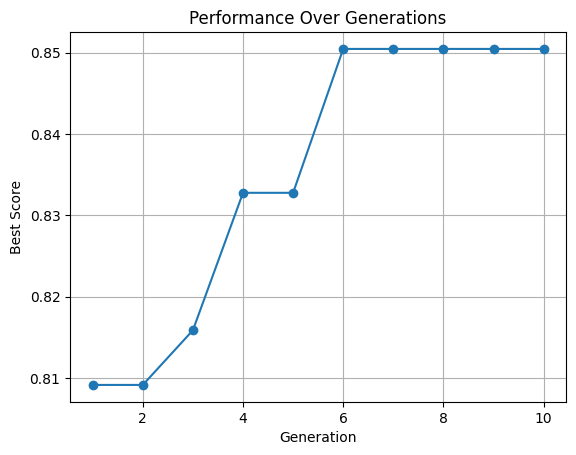

Best Parameters: [0.2, 0.2, 1.6, 1.9, 1.0]
Best Score: 0.8504630449085098


In [45]:
best_individual, best_score = genetic_algorithm(validation, plot_path="performance_plot.png", population_path="last_population.npy")
print("Best Parameters:", best_individual)
print("Best Score:", best_score)